In [ ]:
"""
Activation visualization — one layer per figure, no stacking or PCA.
Simply plots each prompt’s activation vector (mean-pooled if needed).
"""
import os
import numpy as np
import matplotlib.pyplot as plt

# Detect available layers and prompts
layers = sorted({int(f.split("_layer")[1].split(".")[0]) for f in os.listdir("activations")})
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in os.listdir("activations")})

def load_vector(path):
    """Load an activation and safely reduce to 1-D if multi-dimensional."""
    arr = np.load(path)
    while arr.ndim > 1:
        arr = arr.mean(axis=0)
    return arr

for lid in layers:
    plt.figure(figsize=(8, 5))
    for p in prompts:
        path = f"activations/prompt{p:02d}_layer{lid:02d}.npy"
        if not os.path.exists(path):
            continue
        vec = load_vector(path)
        plt.plot(vec, label=f"Prompt {p}", alpha=0.8)
    plt.title(f"Layer {lid} Activation Profiles")
    plt.xlabel("Hidden Dimension Index")
    plt.ylabel("Activation Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


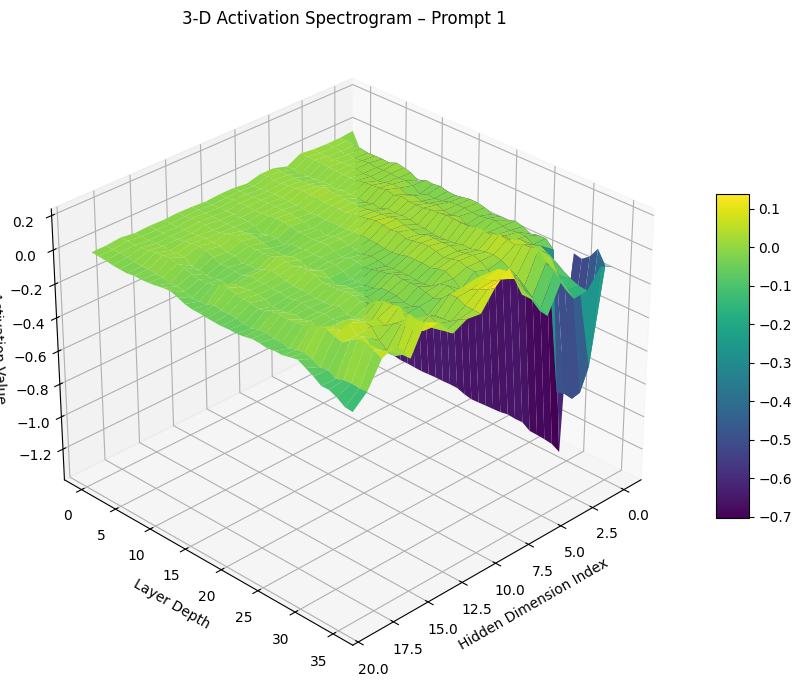

In [1]:
"""
3-D activation spectrogram visualization
Each layer plotted as a 'ribbon' across hidden dimensions.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Discover layers/prompts
layers = sorted({int(f.split("_layer")[1].split(".")[0]) for f in os.listdir("activations")})
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in os.listdir("activations")})

def load_vector(path):
    arr = np.load(path)
    while arr.ndim > 1:
        arr = arr.mean(axis=0)
    return arr

# Pick one prompt to visualize
prompt_id = 1
layer_vectors = []
for lid in layers:
    path = f"activations/prompt{prompt_id:02d}_layer{lid:02d}.npy"
    if os.path.exists(path):
        layer_vectors.append(load_vector(path))

# Convert to matrix (layers × hidden_dim)
# Some layers may have slightly different sizes; pad to max length
max_len = max(v.shape[0] for v in layer_vectors)
mat = np.zeros((len(layer_vectors), max_len))
for i, v in enumerate(layer_vectors):
    mat[i, :v.shape[0]] = v

# Create 3-D spectrogram-like plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

X = np.arange(max_len)
Y = np.arange(len(layer_vectors))
X, Y = np.meshgrid(X, Y)
Z = mat

surf = ax.plot_surface(X, Y, Z, cmap="viridis", linewidth=0, antialiased=True)
ax.set_title(f"3-D Activation Spectrogram – Prompt {prompt_id}")
ax.set_xlabel("Hidden Dimension Index")
ax.set_ylabel("Layer Depth")
ax.set_zlabel("Activation Value")
ax.view_init(elev=30, azim=45)   # adjust angle here
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


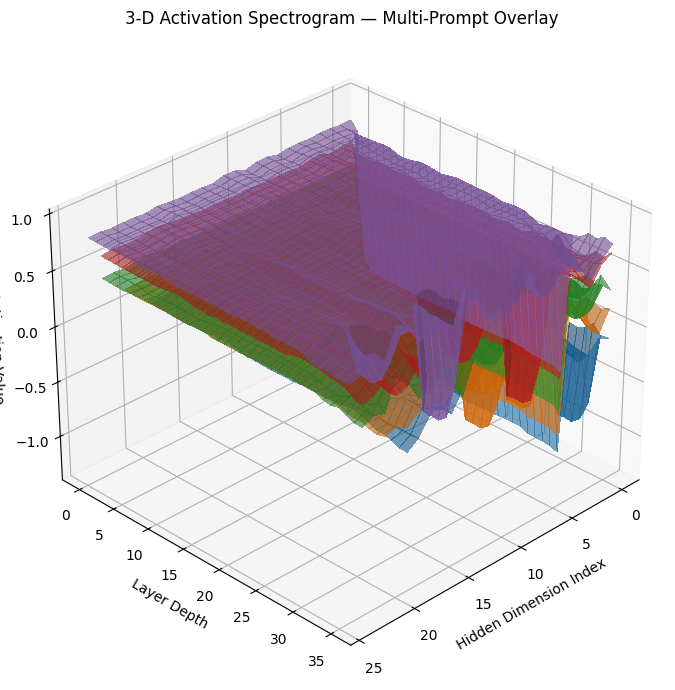

In [2]:
"""
3-D Activation Spectrogram — Multi-Prompt Overlay
Compares activation surfaces across prompts in one figure.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------------------------------------------------------------------
# Load activations
# ---------------------------------------------------------------------
layers = sorted({int(f.split("_layer")[1].split(".")[0]) for f in os.listdir("activations")})
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in os.listdir("activations")})

def load_vector(path):
    arr = np.load(path)
    while arr.ndim > 1:
        arr = arr.mean(axis=0)
    return arr

# pick hidden dimension limit for clarity
max_dims = 64   # adjust to see finer detail
colors = plt.cm.tab10.colors

# ---------------------------------------------------------------------
# Build each prompt’s layer×hidden_dim matrix
# ---------------------------------------------------------------------
prompt_mats = {}
for pid in prompts:
    layer_vectors = []
    for lid in layers:
        path = f"activations/prompt{pid:02d}_layer{lid:02d}.npy"
        if os.path.exists(path):
            v = load_vector(path)[:max_dims]
            layer_vectors.append(v)
    # pad to same hidden length
    max_len = max(v.shape[0] for v in layer_vectors)
    mat = np.zeros((len(layer_vectors), max_len))
    for i, v in enumerate(layer_vectors):
        mat[i, :v.shape[0]] = v
    prompt_mats[pid] = mat

# ---------------------------------------------------------------------
# 3-D plot overlay
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

for idx, pid in enumerate(prompts):
    mat = prompt_mats[pid]
    Y = np.arange(mat.shape[0])  # layers
    X = np.arange(mat.shape[1])  # hidden dims
    X, Y = np.meshgrid(X, Y)
    Z = mat

    # slight vertical offset for visual separation
    offset = idx * 0.2
    surf = ax.plot_surface(
        X, Y, Z + offset,
        color=colors[idx % len(colors)],
        alpha=0.6,
        linewidth=0,
        antialiased=False,
        label=f"Prompt {pid}"
    )

ax.set_title("3-D Activation Spectrogram — Multi-Prompt Overlay")
ax.set_xlabel("Hidden Dimension Index")
ax.set_ylabel("Layer Depth")
ax.set_zlabel("Activation Value")
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()


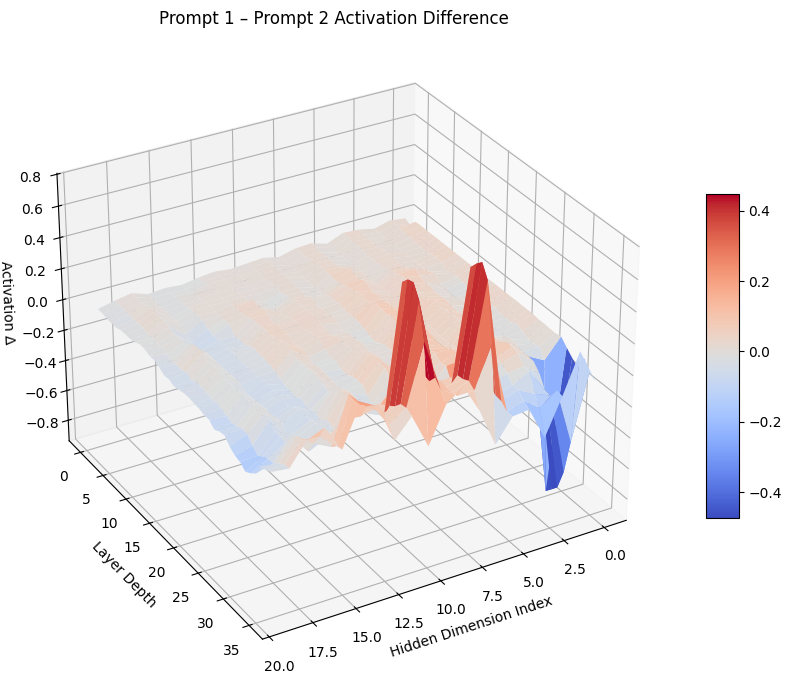

In [3]:
# Prompt contrast: Prompt 1 minus Prompt 2 (safe version)
p1, p2 = 1, 2
m1, m2 = prompt_mats[p1], prompt_mats[p2]

# Align widths
min_len = min(m1.shape[1], m2.shape[1])
m1, m2 = m1[:, :min_len], m2[:, :min_len]

# Compute difference
mat_diff = m1 - m2

# Plot 3-D difference spectrogram
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

Y = np.arange(mat_diff.shape[0])   # layer depth
X = np.arange(mat_diff.shape[1])   # hidden dims
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, mat_diff, cmap="coolwarm", linewidth=0, antialiased=True)
ax.set_title(f"Prompt {p1} – Prompt {p2} Activation Difference")
ax.set_xlabel("Hidden Dimension Index")
ax.set_ylabel("Layer Depth")
ax.set_zlabel("Activation Δ")
ax.view_init(elev=30, azim=60)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


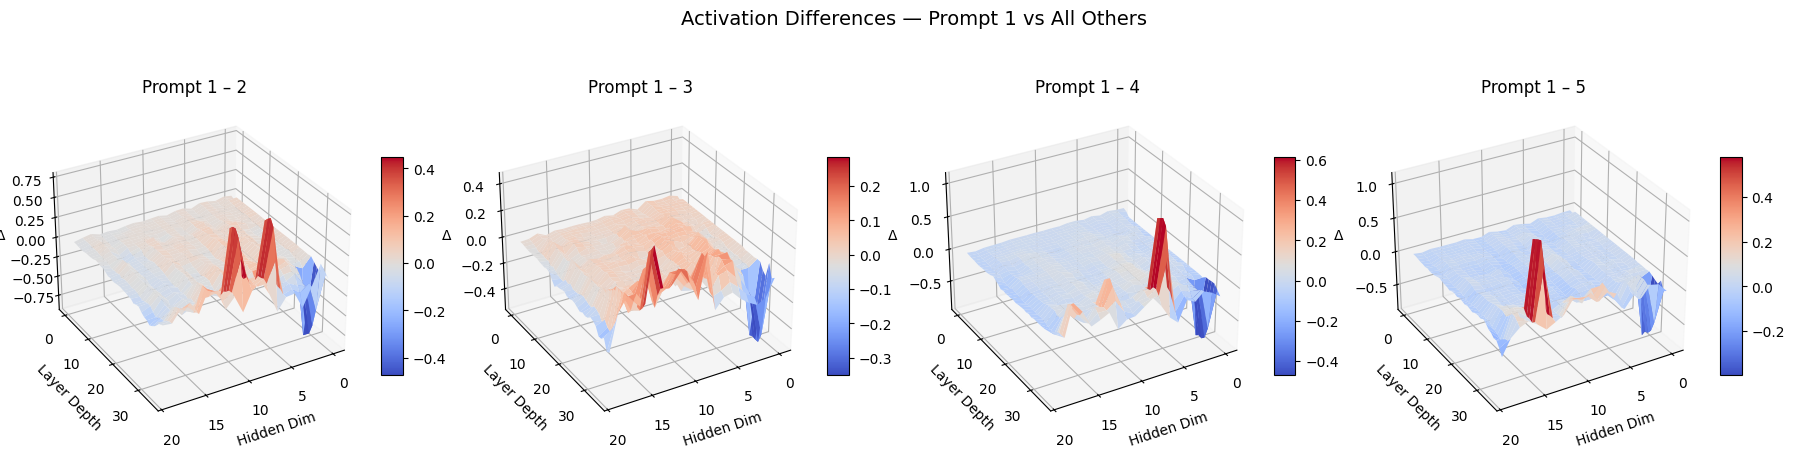

In [7]:
"""
Activation Difference Viewer — One reference prompt vs all others
Shows Prompt 1 – Prompt 2..5 across all layers in a single figure.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------------------------------------------------------------------
# Load activations
# ---------------------------------------------------------------------
layers = sorted({int(f.split("_layer")[1].split(".")[0]) for f in os.listdir("activations")})
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in os.listdir("activations")})

def load_vector(path):
    arr = np.load(path)
    while arr.ndim > 1:
        arr = arr.mean(axis=0)
    return arr

def build_prompt_matrix(pid, max_dims=64):
    mats = []
    for lid in layers:
        path = f"activations/prompt{pid:02d}_layer{lid:02d}.npy"
        if os.path.exists(path):
            v = load_vector(path)[:max_dims]
            mats.append(v)
    max_len = max(v.shape[0] for v in mats)
    mat = np.zeros((len(mats), max_len))
    for i, v in enumerate(mats):
        mat[i, :v.shape[0]] = v
    return mat

prompt_mats = {pid: build_prompt_matrix(pid) for pid in prompts}

# ---------------------------------------------------------------------
# Plot: one prompt vs all others
# ---------------------------------------------------------------------
ref_prompt = 1          # reference prompt ID
compare_to = [p for p in prompts if p != ref_prompt]

fig = plt.figure(figsize=(18, 5))
for idx, p2 in enumerate(compare_to, start=1):
    m1, m2 = prompt_mats[ref_prompt], prompt_mats[p2]
    min_len = min(m1.shape[1], m2.shape[1])
    m1, m2 = m1[:, :min_len], m2[:, :min_len]
    mat_diff = m1 - m2

    ax = fig.add_subplot(1, len(compare_to), idx, projection="3d")
    Y = np.arange(mat_diff.shape[0])
    X = np.arange(mat_diff.shape[1])
    X, Y = np.meshgrid(X, Y)

    surf = ax.plot_surface(
        X, Y, mat_diff,
        cmap="coolwarm",
        linewidth=0,
        antialiased=True
    )
    ax.set_title(f"Prompt {ref_prompt} – {p2}")
    ax.set_xlabel("Hidden Dim")
    ax.set_ylabel("Layer Depth")
    ax.set_zlabel("Δ")
    ax.view_init(elev=30, azim=60)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.suptitle(f"Activation Differences — Prompt {ref_prompt} vs All Others", fontsize=14)
plt.tight_layout()
plt.show()


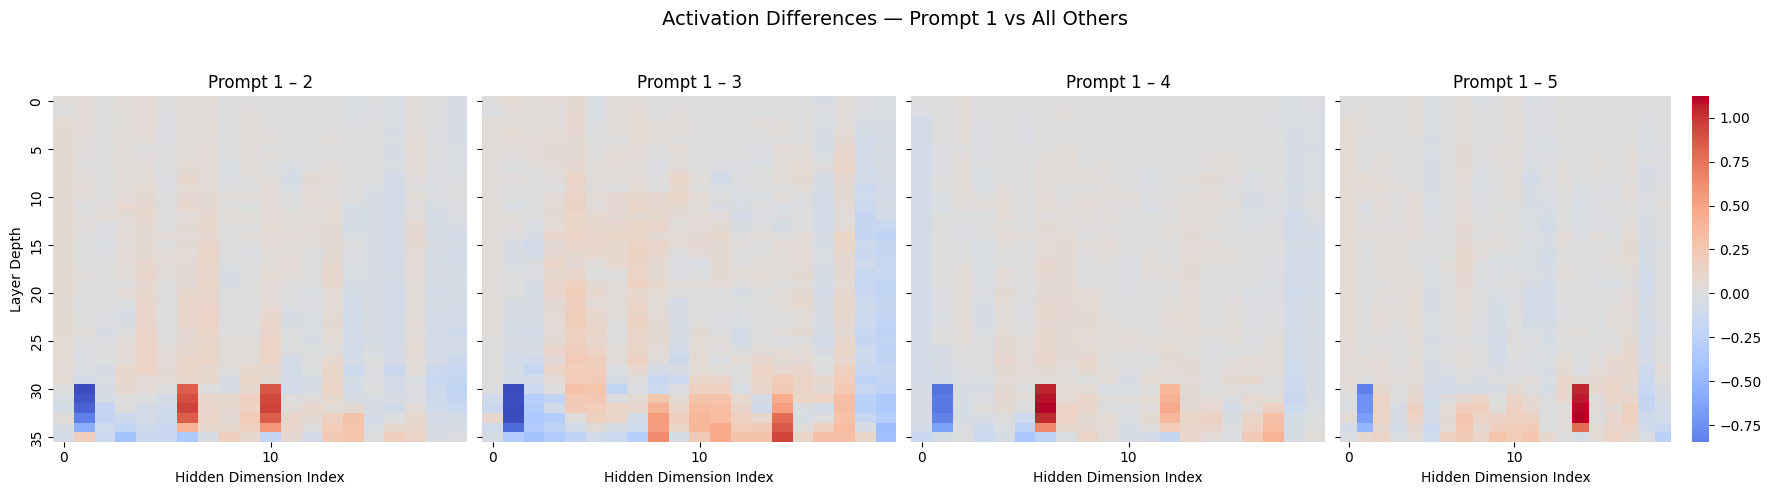

In [8]:
"""
Activation Difference Heatmaps — One reference prompt vs all others
Each subplot shows Prompt 1 – Prompt N difference across all layers.
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# Load activations
# ---------------------------------------------------------------------
layers = sorted({int(f.split("_layer")[1].split(".")[0]) for f in os.listdir("activations")})
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in os.listdir("activations")})

def load_vector(path):
    arr = np.load(path)
    while arr.ndim > 1:
        arr = arr.mean(axis=0)
    return arr

def build_prompt_matrix(pid, max_dims=64):
    mats = []
    for lid in layers:
        path = f"activations/prompt{pid:02d}_layer{lid:02d}.npy"
        if os.path.exists(path):
            v = load_vector(path)[:max_dims]
            mats.append(v)
    max_len = max(v.shape[0] for v in mats)
    mat = np.zeros((len(mats), max_len))
    for i, v in enumerate(mats):
        mat[i, :v.shape[0]] = v
    return mat

prompt_mats = {pid: build_prompt_matrix(pid) for pid in prompts}

# ---------------------------------------------------------------------
# Plot heatmaps
# ---------------------------------------------------------------------
ref_prompt = 1
compare_to = [p for p in prompts if p != ref_prompt]

fig, axes = plt.subplots(1, len(compare_to), figsize=(18, 5), sharex=True, sharey=True)

for idx, p2 in enumerate(compare_to):
    m1, m2 = prompt_mats[ref_prompt], prompt_mats[p2]
    min_len = min(m1.shape[1], m2.shape[1])
    m1, m2 = m1[:, :min_len], m2[:, :min_len]
    mat_diff = m1 - m2

    ax = axes[idx]
    sns.heatmap(
        mat_diff,
        ax=ax,
        cmap="coolwarm",
        center=0,
        cbar=True if idx == len(compare_to)-1 else False,
        xticklabels=10,
        yticklabels=5
    )
    ax.set_title(f"Prompt {ref_prompt} – {p2}")
    ax.set_xlabel("Hidden Dimension Index")
    if idx == 0:
        ax.set_ylabel("Layer Depth")

plt.suptitle(f"Activation Differences — Prompt {ref_prompt} vs All Others", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


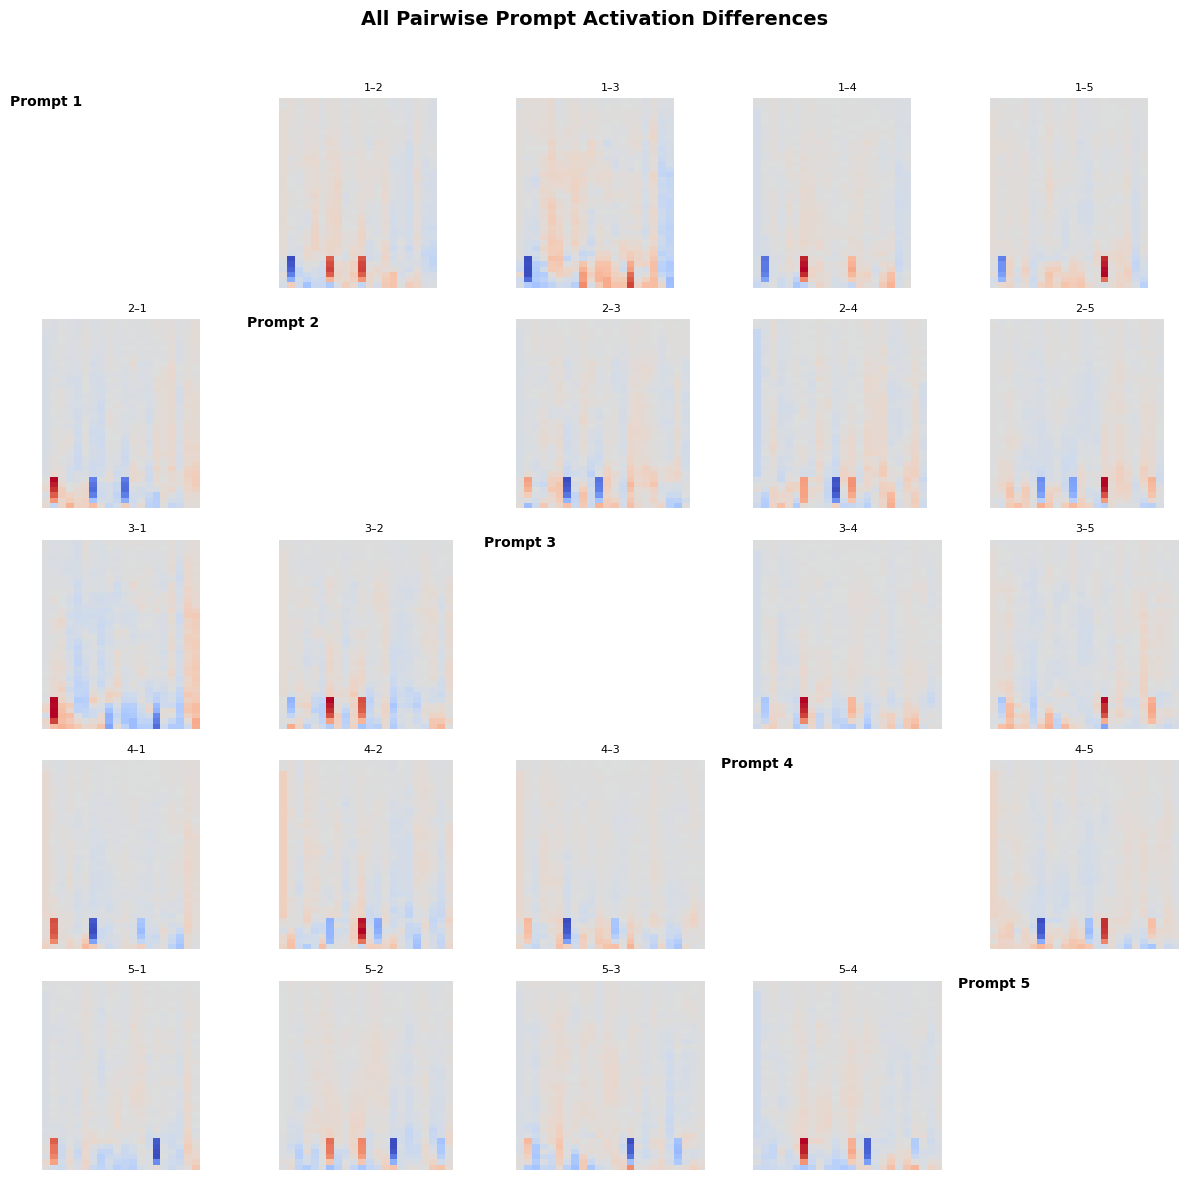

In [10]:
"""
Activation Difference Matrix (All Prompt Pairs)
Displays all pairwise activation difference heatmaps in one composite grid.
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# Load activations
# ---------------------------------------------------------------------
layers = sorted({int(f.split("_layer")[1].split(".")[0]) for f in os.listdir("activations")})
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in os.listdir("activations")})

def load_vector(path):
    arr = np.load(path)
    while arr.ndim > 1:
        arr = arr.mean(axis=0)
    return arr

def build_prompt_matrix(pid, max_dims=64):
    mats = []
    for lid in layers:
        path = f"activations/prompt{pid:02d}_layer{lid:02d}.npy"
        if os.path.exists(path):
            v = load_vector(path)[:max_dims]
            mats.append(v)
    max_len = max(v.shape[0] for v in mats)
    mat = np.zeros((len(mats), max_len))
    for i, v in enumerate(mats):
        mat[i, :v.shape[0]] = v
    return mat

prompt_mats = {pid: build_prompt_matrix(pid) for pid in prompts}

# ---------------------------------------------------------------------
# Create all pairwise heatmaps (matrix view)
# ---------------------------------------------------------------------
n = len(prompts)
fig, axes = plt.subplots(n, n, figsize=(12, 12), sharex=True, sharey=True)

for i, p1 in enumerate(prompts):
    for j, p2 in enumerate(prompts):
        ax = axes[i, j]
        if i == j:
            ax.axis("off")
            ax.text(0.5, 0.5, f"Prompt {p1}", ha="center", va="center", fontsize=10, fontweight="bold")
            continue

        m1, m2 = prompt_mats[p1], prompt_mats[p2]
        min_len = min(m1.shape[1], m2.shape[1])
        m1, m2 = m1[:, :min_len], m2[:, :min_len]
        mat_diff = m1 - m2

        sns.heatmap(
            mat_diff,
            ax=ax,
            cmap="coolwarm",
            center=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False
        )

        ax.set_title(f"{p1}–{p2}", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")

fig.suptitle("All Pairwise Prompt Activation Differences", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
